# Welcome to our Google Colab Notebook!
In this notebook we will go through all the steps that are also implemented in knime *with more explainations and plots along the way.*
First you need to upload the data as zip or folders to your google drive.
You will need to setup the file directions on your drives in these variables:
mens_path = '/content/drive/MyDrive/ETH/Soccer Analytics/fmwc2022/'
womens_path = '/content/drive/MyDrive/ETH/Soccer Analytics/fwwc2023/'

You can run the commented lines to extract the zip if you uploaded the files as zip.
After running the first cell and mounting your drive you can check the locations of the files by searching through the file navigator to the left of google colab UI and under the drive folder. If it doesn't show up, do right click--> refresh.

Other than that you are good to go. You can run one by one all the cells. Enjoy :)


In [1]:
%load_ext autoreload
%autoreload 2

# Import some useful libraries
%matplotlib inline

import os
import sys
import time
import h5py
import yaml
import shutil
from pathlib import Path
from zipfile import ZipFile
import json
from pandas import json_normalize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm
drive_path = Path('/content/drive')
drive.mount(str(drive_path))




Mounted at /content/drive


In [ ]:
"""ONLY DO ONCE
with ZipFile('/content/drive/MyDrive/ETH/Soccer Analytics/fmwc2022.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ETH/Soccer Analytics/fmwc2022')

with ZipFile('/content/drive/MyDrive/ETH/Soccer Analytics/fwwc2023.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ETH/Soccer Analytics/fwwc2023')
"""

mens_path = '/content/drive/MyDrive/ETH/Soccer Analytics/fmwc2022/'
womens_path = '/content/drive/MyDrive/ETH/Soccer Analytics/fwwc2023/'
lst_competitions = [mens_path, womens_path]
mens_path = drive_path / mens_path
womens_path = drive_path / womens_path

# Possibly append to PATH
if mens_path not in sys.path:
    sys.path.append(str(mens_path))
if womens_path not in sys.path:
    sys.path.append(str(womens_path))

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore")

# Data Scraping
Read the general info about the competition
Custom JSON functions to read matches.json file

In [2]:
# Define custom functions for used in the notebook
from io import BytesIO

## Function to read JSON files that also handles the encoding of special characters e.g. accents in names of players and teams
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')


## Function to flatten pandas DataFrames with nested JSON columns. Source: https://stackoverflow.com/questions/39899005/how-to-flatten-a-pandas-dataframe-with-some-columns-as-json
def flatten_nested_json_df(df):

    df = df.reset_index()

    print(f"original shape: {df.shape}")
    print(f"original columns: {df.columns}")


    # search for columns to explode/flatten
    s = (df.applymap(type) == list).all()
    list_columns = s[s].index.tolist()

    s = (df.applymap(type) == dict).all()
    dict_columns = s[s].index.tolist()

    print(f"lists: {list_columns}, dicts: {dict_columns}")
    while len(list_columns) > 0 or len(dict_columns) > 0:
        new_columns = []

        for col in dict_columns:
            print(f"flattening: {col}")
            # explode dictionaries horizontally, adding new columns
            horiz_exploded = pd.json_normalize(df[col]).add_prefix(f'{col}.')
            horiz_exploded.index = df.index
            df = pd.concat([df, horiz_exploded], axis=1).drop(columns=[col])
            new_columns.extend(horiz_exploded.columns) # inplace

        for col in list_columns:
            print(f"exploding: {col}")
            # explode lists vertically, adding new columns
            df = df.drop(columns=[col]).join(df[col].explode().to_frame())
            new_columns.append(col)

        # check if there are still dict o list fields to flatten
        s = (df[new_columns].applymap(type) == list).all()
        list_columns = s[s].index.tolist()

        s = (df[new_columns].applymap(type) == dict).all()
        dict_columns = s[s].index.tolist()

        print(f"lists: {list_columns}, dicts: {dict_columns}")

    print(f"final shape: {df.shape}")
    print(f"final columns: {df.columns}")
    return df

Read Matches Data

In [3]:
json_men = read_json_file(str(mens_path) + "/matches.json")
df_men_flat = pd.read_json(json_men)
lst_matches_men = df_men_flat["match_id"].tolist()

json_women = read_json_file(str(womens_path) + "/matches.json")
df_women_flat = pd.read_json(json_women)
lst_matches_women = df_women_flat["match_id"].tolist()


Read events.json files

The [StatsBomb](https://statsbomb.com/) dataset has one hundred and fourteen features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `id`    | `object`
| `index`    | `object`
| `period`    | `object`
| `timestamp`    | `object`
| `minute`    | `object`
| `second`    | `object`
| `possession`    | `object`
| `duration`    | `object`
| `type.id`    | `object`
| `type.name`    | `object`
| `possession_team.id`    | `object`
| `possession_team.name`    | `object`
| `play_pattern.id`    | `object`
| `play_pattern.name`    | `object`
| `team.id`    | `object`
| `team.name`    | `object`
| `tactics.formation`    | `object`
| `tactics.lineup`    | `object`
| `related_events`    | `object`
| `location`    | `object`
| `player.id`    | `object`
| `player.name`    | `object`
| `position.id`    | `object`
| `position.name`    | `object`
| `pass.recipient.id`    | `object`
| `pass.recipient.name`    | `object`
| `pass.length`    | `object`
| `pass.angle`    | `object`
| `pass.height.id`    | `object`
| `pass.height.name`    | `object`
| `pass.end_location`    | `object`
| `pass.type.id`    | `object`
| `pass.type.name`    | `object`
| `pass.body_part.id`    | `object`
| `pass.body_part.name`    | `object`
| `carry.end_location`    | `object`
| `under_pressure`    | `object`
| `duel.type.id`    | `object`
| `duel.type.name`    | `object`
| `out`    | `object`
| `miscontrol.aerial_won`    | `object`
| `pass.outcome.id`    | `object`
| `pass.outcome.name`    | `object`
| `ball_receipt.outcome.id`    | `object`
| `ball_receipt.outcome.name`    | `object`
| `pass.aerial_won`    | `object`
| `counterpress`    | `object`
| `off_camera`    | `object`
| `dribble.outcome.id`    | `object`
| `dribble.outcome.name`    | `object`
| `dribble.overrun`    | `object`
| `ball_recovery.offensive`    | `object`
| `shot.statsbomb_xg`    | `object`
| `shot.end_location`    | `object`
| `shot.outcome.id`    | `object`
| `shot.outcome.name`    | `object`
| `shot.type.id`    | `object`
| `shot.type.name`    | `object`
| `shot.body_part.id`    | `object`
| `shot.body_part.name`    | `object`
| `shot.technique.id`    | `object`
| `shot.technique.name`    | `object`
| `shot.freeze_frame`    | `object`
| `goalkeeper.end_location`    | `object`
| `goalkeeper.type.id`    | `object`
| `goalkeeper.type.name`    | `object`
| `goalkeeper.position.id`    | `object`
| `goalkeeper.position.name`    | `object`
| `pass.straight`    | `object`
| `pass.technique.id`    | `object`
| `pass.technique.name`    | `object`
| `clearance.head`    | `object`
| `clearance.body_part.id`    | `object`
| `clearance.body_part.name`    | `object`
| `pass.switch`    | `object`
| `duel.outcome.id`    | `object`
| `duel.outcome.name`    | `object`
| `foul_committed.advantage`    | `object`
| `foul_won.advantage`    | `object`
| `pass.cross`    | `object`
| `pass.assisted_shot_id`    | `object`
| `pass.shot_assist`    | `object`
| `shot.one_on_one`    | `object`
| `shot.key_pass_id`    | `object`
| `goalkeeper.body_part.id`    | `object`
| `goalkeeper.body_part.name`    | `object`
| `goalkeeper.technique.id`    | `object`
| `goalkeeper.technique.name`    | `object`
| `goalkeeper.outcome.id`    | `object`
| `goalkeeper.outcome.name`    | `object`
| `clearance.aerial_won`    | `object`
| `foul_committed.card.id`    | `object`
| `foul_committed.card.name`    | `object`
| `foul_won.defensive`    | `object`
| `clearance.right_foot`    | `object`
| `shot.first_time`    | `object`
| `pass.through_ball`    | `object`
| `interception.outcome.id`    | `object`
| `interception.outcome.name`    | `object`
| `clearance.left_foot`    | `object`
| `ball_recovery.recovery_failure`    | `object`
| `shot.aerial_won`    | `object`
| `pass.goal_assist`    | `object`
| `pass.cut_back`    | `object`
| `pass.deflected`    | `object`
| `clearance.other`    | `object`
| `pass.outswinging`    | `object`
| `substitution.outcome.id`    | `object`
| `substitution.outcome.name`    | `object`
| `substitution.replacement.id`    | `object`
| `substitution.replacement.name`    | `object`
| `block.deflection`    | `object`
| `block.offensive`    | `object`
| `injury_stoppage.in_chain`    | `object`

For a full list of definitions, see the official documentation [[link](https://statsbomb.com/stat-definitions/)].

##Working with Events data

In [4]:
dfs_eventsM = []
### Loop through event files for the selected matches and append DataFrame to dfs_events list
for match_id in lst_matches_men:

    ####
    with open(str(mens_path)+ "/events/" + str(match_id) + '.json') as f:
        event = json.load(f)
        #match_id = str(match_id)
        event = json_normalize(event)
        event['match_id'] = match_id
        dfs_eventsM.append(event)

### Concatenate DataFrames to one DataFrame
df_eventsM = pd.concat(dfs_eventsM)

### Flatten the nested columns
eventsM = flatten_nested_json_df(df_eventsM)


#------------------------------------------------------
dfs_eventsW = []
### Loop through event files for the selected matches and append DataFrame to dfs_events list
for match_id in lst_matches_women:

    ####
    with open(str(womens_path)+ "/events/" + str(match_id) + '.json') as f:
        event = json.load(f)
        #match_id = str(match_id)
        event = json_normalize(event)
        event['match_id'] = match_id
        dfs_eventsW.append(event)

### Concatenate DataFrames to one DataFrame
df_eventsW = pd.concat(dfs_eventsW)

### Flatten the nested columns
eventsW = flatten_nested_json_df(df_eventsW)


original shape: (234652, 143)
original columns: Index(['level_0', 'id', 'index', 'period', 'timestamp', 'minute', 'second',
       'possession', 'duration', 'type.id',
       ...
       'goalkeeper.punched_out', 'block.save_block', 'shot.saved_to_post',
       'goalkeeper.shot_saved_to_post', 'half_start.late_video_start',
       'shot.saved_off_target', 'goalkeeper.shot_saved_off_target',
       'goalkeeper.success_in_play', 'shot.redirect',
       'goalkeeper.lost_in_play'],
      dtype='object', length=143)
lists: [], dicts: []
final shape: (234652, 143)
final columns: Index(['level_0', 'id', 'index', 'period', 'timestamp', 'minute', 'second',
       'possession', 'duration', 'type.id',
       ...
       'goalkeeper.punched_out', 'block.save_block', 'shot.saved_to_post',
       'goalkeeper.shot_saved_to_post', 'half_start.late_video_start',
       'shot.saved_off_target', 'goalkeeper.shot_saved_off_target',
       'goalkeeper.success_in_play', 'shot.redirect',
       'goalkeeper.los

#Read 360 .JSON files

In [5]:
events360M = []
### Loop through event files for the selected matches and append DataFrame to dfs_events list
for match_id in tqdm(lst_matches_men):

    ####
    with open(str(mens_path)+ "/three-sixty/" + str(match_id) + '.json') as f:
        #print(f)
        event360 = json.load(f)
        #match_id = str(match_id)
        event360 = json_normalize(event360)
        event360['match_id'] = match_id
        ### Flatten the nested columns
        #event360 = flatten_nested_json_df(event360)

        events360M.append(event360)

### Concatenate DataFrames to one DataFrame
events360M= pd.concat(events360M)

#-----------------------------------
events360W = []
### Loop through event files for the selected matches and append DataFrame to dfs_events list
for match_id in tqdm(lst_matches_women):

    ####
    with open(str(womens_path)+ "/three-sixty/" + str(match_id) + '.json') as f:
        #print(f)
        event360 = json.load(f)
        #match_id = str(match_id)
        event360 = json_normalize(event360)
        event360['match_id'] = match_id
        ### Flatten the nested columns
        #event360 = flatten_nested_json_df(event360)

        events360W.append(event360)

### Concatenate DataFrames to one DataFrame
events360W= pd.concat(events360W)


100%|██████████| 64/64 [00:35<00:00,  1.79it/s]


In [ ]:
print(events360M.shape)
print(events360W.shape)

(203887, 4)
(199259, 4)


#Data Engineering


Correct Possible errors

In [6]:
# Replace dots (.) in column names with an underscore (_)
eventsM.columns = eventsM.columns.str.replace('[.]', '_')
eventsW.columns =eventsW.columns.str.replace('[.]', '_')
events360M.columns = events360M.columns.str.replace('[.]', '_')
events360W.columns =events360W.columns.str.replace('[.]', '_')

Check How many matches we have

In [ ]:
print(len(eventsM))
print(len(eventsW))

234652
226146


## Extract Features from event data


Calculate Seconds per match

In [7]:
def convert_to_seconds(time_str):
    parts = time_str.split(':')
    h, m = map(int, parts[:2] )
    s = int(np.round(float(parts[2])))
    return h * 3600 + m * 60 + s

def get_total_seconds(events):
  return (events['real_time']).max()

def add_real_time(events):

    # Initialize a variable to keep track of the offset
    offset_seconds = 0
    periods = min(len(events["period"].unique()), 4)
    # Iterate over each period and adjust timestamps
    for period in range(periods):

        max_timestamp = (events[events["period"]==period+1])['timestamp'].apply(convert_to_seconds).max()
        # Apply the offset to the current period events
        events.loc[events['period'] == period+1, 'real_time'] = (events[events["period"]==period+1])['timestamp'].apply(convert_to_seconds).copy() + offset_seconds

        # Update the offset for the next period
        offset_seconds += max_timestamp
    return events


match_statsM = pd.DataFrame({'match_id': eventsM['match_id'].unique()})
modified_eventsM = pd.DataFrame()
matchesM = eventsM["match_id"].unique()
match_statsM['duration'] = 0
for match_id in matchesM:
  modified_event = add_real_time(eventsM[eventsM["match_id"]==match_id])
  modified_eventsM = modified_eventsM.append(modified_event)
  match_duration = get_total_seconds(modified_eventsM[modified_eventsM["match_id"]==match_id])
  match_statsM.loc[match_statsM['match_id'] == match_id, 'duration'] = match_duration
eventsM = modified_eventsM

#-------------------------------------

match_statsW = pd.DataFrame({'match_id': eventsW['match_id'].unique()})
modified_eventsW = pd.DataFrame()
matchesW = eventsW["match_id"].unique()
match_statsW['duration'] = 0
for match_id in matchesW:
  modified_event = add_real_time(eventsW[eventsW["match_id"]==match_id])
  modified_eventsW = modified_eventsW.append(modified_event)
  match_duration = get_total_seconds(modified_eventsW[modified_eventsW["match_id"]==match_id])
  match_statsW.loc[match_statsW['match_id'] == match_id, 'duration'] = match_duration
eventsW = modified_eventsW

Calculate Features

In [32]:
def get_total(type_name, keyword, match_events):
  return match_events[match_events[type_name] == keyword].shape[0]

def mad(arr, axis=None, keepdims=True):
    median = np.median(arr, axis=axis, keepdims=True)
    mad = np.median(np.abs(arr-median),axis=axis, keepdims=keepdims)
    return mad

def get_time_mean_std(type_name, keyword, match_events):
  action_events = match_events[match_events[type_name] == keyword].copy()
  if not action_events.empty:
    end_of_match = action_events.iloc[0].copy()
    end_of_match['real_time'] += (match_events['real_time']).max()
    action_events = action_events.append(end_of_match, ignore_index=True)
    time_diffs = action_events['real_time'].diff().dropna()
    mean_diff = time_diffs.mean()
    std_diff = time_diffs.std()
    #mean_diff = time_diffs.median()
    #std_diff = time_diffs.mad()
  else:
    mean_diff = np.nan
    std_diff = np.nan
  return mean_diff, std_diff

def get_position_mean_std(type_name, keyword, match_events):
  action_events = match_events[match_events[type_name] == keyword].copy()
  if not action_events.empty:
    #x_mean = action_events['location'].apply(lambda loc: loc[0] if isinstance(loc, (list, tuple)) and len(loc) > 0 else np.nan).median()
    #x_std = action_events['location'].apply(lambda loc: loc[0] if isinstance(loc, (list, tuple)) and len(loc) > 0 else np.nan).mad()
    #y_mean = action_events['location'].apply(lambda loc: loc[1] if isinstance(loc, (list, tuple)) and len(loc) > 1 else np.nan).median()
    #y_std = action_events['location'].apply(lambda loc: loc[1] if isinstance(loc, (list, tuple)) and len(loc) > 1 else np.nan).mad()

    x_mean = action_events['location'].apply(lambda loc: loc[0] if isinstance(loc, (list, tuple)) and len(loc) > 0 else np.nan).mean()
    x_std = action_events['location'].apply(lambda loc: loc[0] if isinstance(loc, (list, tuple)) and len(loc) > 0 else np.nan).std()
    y_mean = action_events['location'].apply(lambda loc: loc[1] if isinstance(loc, (list, tuple)) and len(loc) > 1 else np.nan).mean()
    y_std = action_events['location'].apply(lambda loc: loc[1] if isinstance(loc, (list, tuple)) and len(loc) > 1 else np.nan).std()

  else:
    x_mean = np.nan
    x_std = np.nan
    y_mean = np.nan
    y_std = np.nan
  return x_mean, x_std, y_mean, y_std

def get_pass_acc (match_events):
  action_events = match_events[match_events["type_name"] == "Pass"].copy()
  total = action_events.shape[0] - action_events[action_events["pass_outcome_name"] == "Unknown"].shape[0] - action_events[action_events["pass_outcome_name"] == "Pass Offside"].shape[0] - action_events[action_events["pass_outcome_name"] == "Injury Clearance"].shape[0]
  total_success = total - action_events[action_events["pass_outcome_name"] == "Out"].shape[0] - action_events[action_events["pass_outcome_name"] == "Incomplete"].shape[0]
  acc = total_success / total

  #length = action_events['pass_length'].dropna().median()
  length = action_events['pass_length'].dropna().mean()
  return acc , length

def get_shot_acc (match_events):
  action_events = match_events[match_events["type_name"] == "Shot"].copy()
  total = action_events.dropna().shape[0] - action_events[action_events["shot_outcome_name"] == "Blocked"].shape[0]
  total_success = total - action_events[action_events["shot_outcome_name"] == "Off T"].shape[0] - action_events[action_events["shot_outcome_name"] == "Post"].shape[0] - action_events[action_events["shot_outcome_name"] == "Wayward"].shape[0]
  eps = 0.0001
  acc = total_success / (eps+total)
  return acc

def get_possession_duration(match_events):
    # Group by 'possession' and calculate the duration of each possession
    possession_durations = match_events.groupby('possession')['real_time'].agg(['min', 'max'])
    possession_durations['duration'] = possession_durations['max'] - possession_durations['min']

    # Calculate mean and std of possession durations
    mean_duration = possession_durations['duration'].mean()
    std_duration = possession_durations['duration'].std()
    #mean_duration = possession_durations['duration'].median()
    #std_duration = possession_durations['duration'].mad()

    return mean_duration, std_duration

def calculate_time_wasted(match_events):
    # Filter for 'Foul Won' events
    foul_events = match_events[match_events["type_name"] == "Foul Won"]

    # Initialize a list to store time differences
    time_diffs = []

    # Iterate over foul events
    for index, foul_event in foul_events.iterrows():
        # Find the index of the next event
        next_event_index = index + 1

        # Check if the next event exists in the DataFrame
        if next_event_index in match_events.index:
            next_event = match_events.loc[next_event_index]

            # Calculate time difference
            time_diff = next_event['real_time'] - foul_event['real_time']
            time_diffs.append(time_diff)

    # Calculate mean and std of time differences
    if time_diffs:
        mean_diff = np.mean(time_diffs)
        std_duration = np.std(time_diffs)
        #mean_diff = np.median(time_diffs)
        #std_duration = mad(time_diffs)
    else:
        mean_diff, std_duration = np.nan, np.nan

    return mean_diff, std_duration

## Appearance Frequency Features
type_features =  ["Pass", "Ball Receipt*","Carry" , "Clearance" , "Ball Recovery", "Shot", "Block", "Goal Keeper", "Miscontrol", "Pressure", "Duel", "Interception", "Foul Committed", "Dispossessed",
                  "Dribble" , "Injury Stoppage", "Substitution", "Bad Behaviour", "Player Off", "Own Goal Against", "50/50" ]
pass_height_features = ["Ground Pass", "High Pass", "Low Pass" ]
body_parts_features = ['Right Foot', 'Left Foot', 'Head', 'Keeper Arm', 'Other', 'No Touch' ,'Drop Kick']
pass_type_features = [ 'Kick Off', 'Recovery', 'Throw-in', 'Corner', 'Goal Kick', 'Free Kick', 'Interception']
shot_technique_features = ['Half Volley' ,'Normal', 'Volley', 'Backheel', 'Diving Header', 'Lob' ,'Overhead Kick']
play_pattern_features = ['Regular Play', 'From Kick Off', 'From Throw In', 'From Corner', 'From Goal Kick', 'From Free Kick', 'From Keeper', 'From Counter', 'Other']
pass_outcome_name = ["Pass Offside"]
#summarize all features in a dictionary
simple_features = {"type_name":type_features, "pass_height_name":pass_height_features, "pass_body_part_name":body_parts_features,
                   "play_pattern_name": play_pattern_features, "pass_type_name": pass_type_features,"shot_technique_name": shot_technique_features, "pass_outcome_name":pass_outcome_name}

# Positional Features
positional_features = ["Pass", "Shot", "Dribble", "Clearance", "Pressure", "Interception"]
matches_list = [matchesM, matchesW]
events_list = [eventsM, eventsW]
match_stats = [match_statsM, match_statsW]
for gender in tqdm(range(2)):
  for match_id in tqdm(matches_list[gender]):
    match_events = events_list[gender][events_list[gender]["match_id"] == match_id]
    for feature_type in simple_features:
      for feature in simple_features[feature_type]:
        mean, std =  get_time_mean_std(feature_type, feature, match_events)

        match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, feature+"_mean"] = mean
        match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, feature+"_std"] = std

    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Shot_accuracy"] = get_shot_acc(match_events)
    pass_acc, pass_length = get_pass_acc(match_events)
    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Pass_accuracy"] = pass_acc
    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Pass_length"] = pass_length

    mean, std = get_possession_duration(match_events)
    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Possession_duration_mean"] = mean
    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Possession_duration_std"] = std

    mean, std = calculate_time_wasted(match_events)
    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Time_waste_mean"] = mean
    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Time_waste_std"] = std

    for feature in positional_features:
      meanx, stdx, meany, stdy = get_position_mean_std("type_name", feature, match_events)

      match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, feature+"_pos_mean_x"] = meanx
      match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, feature+"_pos_std_x"] = stdx
      match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, feature+"_pos_mean_y"] = meany
      match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, feature+"_pos_std_y"] = stdy

    #Do Offside separatly because its under another type name
    meanx, stdx, meany, stdy = get_position_mean_std("pass_outcome_name", "Pass Offside", match_events)
    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Offside"+"_pos_mean_x"] = meanx
    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Offside"+"_pos_std_x"] = stdx
    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Offside"+"_pos_mean_y"] = meany
    match_stats[gender].loc[match_stats[gender]['match_id'] == match_id, "Offside"+"_pos_std_y"] = stdy





100%|██████████| 2/2 [02:45<00:00, 82.74s/it]


##Plot locations to understand field coordinates

Plot for a match the shot location

['Argentina' 'France']


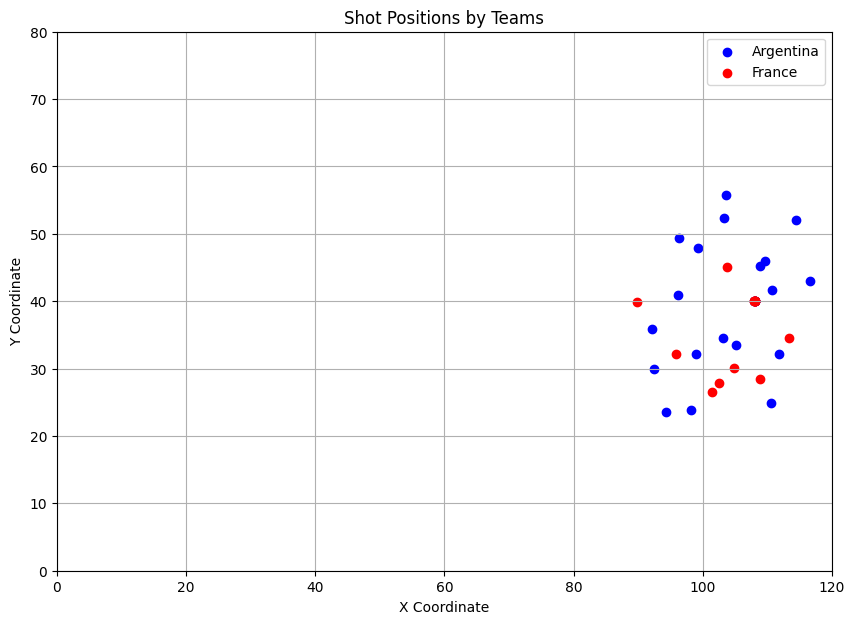

In [ ]:
import matplotlib.pyplot as plt

def plot_shot_positions(match_events):
    # Filter for shots
    shots = match_events[match_events['type_name'] == 'Shot']

    # Assuming 'location' column is in the format [x, y]
    shots['x'] = shots['location'].apply(lambda loc: loc[0] if isinstance(loc, list) and len(loc) > 0 else None)
    shots['y'] = shots['location'].apply(lambda loc: loc[1] if isinstance(loc, list) and len(loc) > 1 else None)
    team_names = shots["team_name"].unique()
    print(team_names)

    # Plotting
    plt.figure(figsize=(10, 7))
    plt.scatter(shots[shots['team_name'] ==team_names[0]]['x'], shots[shots['team_name'] == team_names[0]]['y'], c='blue', label=team_names[0])
    plt.scatter(shots[shots['team_name'] == team_names[1]]['x'], shots[shots['team_name'] == team_names[1]]['y'], c='red', label=team_names[1])

    plt.title('Shot Positions by Teams')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    # Set x and y limits
    plt.xlim(0, 120)
    plt.ylim(0, 80)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
match_events = events_list[0][events_list[0]["match_id"] == 3869685]
plot_shot_positions(match_events)


Plot the clearance shot location per match

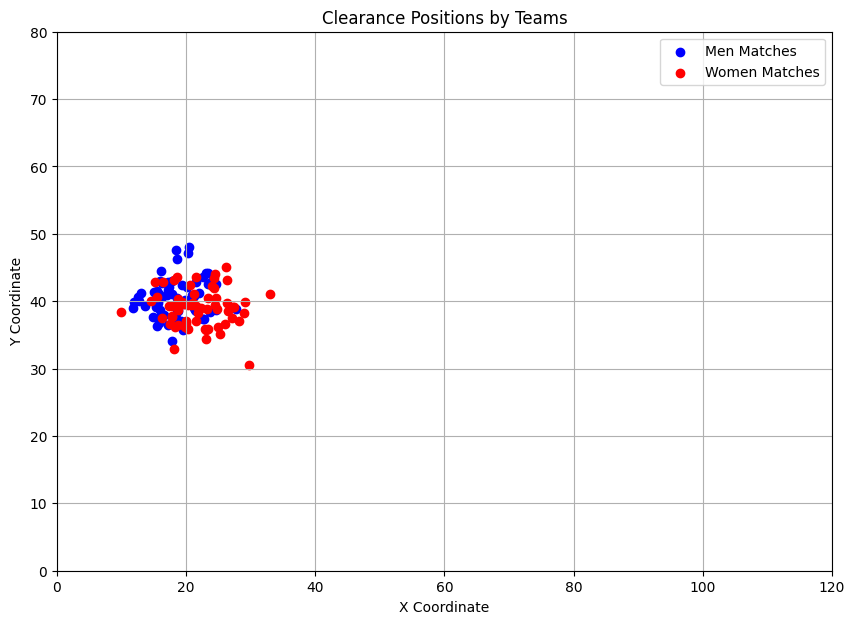

In [ ]:
import matplotlib.pyplot as plt

def plot_shot_means(match_stats):
    # Plotting
    plt.figure(figsize=(10, 7))
    plt.scatter(match_stats[0]["Clearance_pos_mean_x"], match_stats[0]["Clearance_pos_mean_y"], c='blue', label="Men Matches")
    plt.scatter(match_stats[1]["Clearance_pos_mean_x"], match_stats[1]["Clearance_pos_mean_y"], c='red', label="Women Matches")

    plt.title('Clearance Positions by Teams')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    # Set x and y limits
    plt.xlim(0, 120)
    plt.ylim(0, 80)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_shot_means(match_stats)


## Extract features from event360 data

In [9]:
from scipy.spatial import ConvexHull
import numpy as np
from scipy.spatial.distance import pdist, squareform

def calculate_area_stats(frames):
    areas = []

    for frame in frames["freeze_frame"]:
        # Extract locations of opposing team players
        locations = [player['location'] for player in frame if not player['teammate'] and 'location' in player]

        if len(locations) >= 3:  # At least 3 points are needed to form a polygon
            hull = ConvexHull(locations)
            areas.append(hull.area)

    # Calculate mean and std of areas
    mean_area = np.mean(areas) if areas else np.nan
    std_area = np.std(areas) if areas else np.nan

    return mean_area, std_area

def calculate_team_dimensions(frames):
    defending_dims, attacking_dims = [], []

    for frame in frames["freeze_frame"]:
        # Separate defending and attacking players
        defending_locations = [player['location'] for player in frame if not player['teammate'] and 'location' in player]
        attacking_locations = [player['location'] for player in frame if player['teammate'] and 'location' in player]

        # Calculate dimensions
        if defending_locations:
            x_vals, y_vals = zip(*defending_locations)
            defending_dims.append((max(x_vals) - min(x_vals), max(y_vals) - min(y_vals)))  # (width, height)

        if attacking_locations:
            x_vals, y_vals = zip(*attacking_locations)
            attacking_dims.append((max(x_vals) - min(x_vals), max(y_vals) - min(y_vals)))  # (width, height)

    # Convert to numpy array for easy mean and std calculation
    defending_dims = np.array(defending_dims)
    attacking_dims = np.array(attacking_dims)

    return defending_dims.mean(axis=0), defending_dims.std(axis=0), attacking_dims.mean(axis=0), attacking_dims.std(axis=0)

def calculate_players_in_radius(frames, radius = 3):
    player_counts = []

    for frame in frames["freeze_frame"]:
        # Find the actor player
        actor = next((player for player in frame if player.get('actor') and player.get('location')), None)

        if actor and actor['location'][0] > 80:
            actor_loc = actor['location']

            # Count non-teammate players within a radius of 3 units from the actor
            count = sum(np.sqrt((player['location'][0] - actor_loc[0])**2 +
                                (player['location'][1] - actor_loc[1])**2) <= radius
                        for player in frame if not player.get('teammate'))

            player_counts.append(count)

    # Calculate mean and std
    mean_count = np.mean(player_counts) if player_counts else np.nan
    std_count = np.std(player_counts) if player_counts else np.nan

    return mean_count, std_count

def is_point_near_line(point, line_start, line_end, threshold=2.0):
    # Function to check if a point is near a line within a certain threshold
    px, py = point
    x1, y1 = line_start
    x2, y2 = line_end

    # Ensure line is not a single point
    if (x1, y1) == (x2, y2):
        return np.hypot(px - x1, py - y1) <= threshold

    # Calculate the projection of the point onto the line (defined by line_start and line_end)
    norm = np.hypot(x2 - x1, y2 - y1)
    u = ((px - x1) * (x2 - x1) + (py - y1) * (y2 - y1)) / (norm ** 2)

    # The point of intersection on the line segment
    closest_point = np.array([x1, y1]) + u * np.array([x2 - x1, y2 - y1])

    # Check if closest point is within line segment
    if u < 0 or u > 1:
        return False

    # Distance from the point to the closest point on the line segment
    distance = np.hypot(px - closest_point[0], py - closest_point[1])

    return distance <= threshold

def calculate_open_passing_lanes(frames):
    open_lanes_counts = []

    for frame in frames["freeze_frame"]:
        # Find the actor
        actor = next((p for p in frame if p.get('actor') and p.get('location')), None)
        if not actor:
            continue

        # Create lines to each teammate
        teammates = [p for p in frame if p.get('teammate') and p.get('location')]
        opponents = [p for p in frame if not p.get('teammate') and p.get('location')]
        actor_loc = actor['location']
        open_lanes = 0

        for teammate in teammates:
            teammate_loc = teammate['location']
            if all(not is_point_near_line(opponent['location'], actor_loc, teammate_loc) for opponent in opponents):
                open_lanes += 1

        open_lanes_counts.append(open_lanes)

    # Calculate mean and std of open lanes
    mean_lanes = np.mean(open_lanes_counts) if open_lanes_counts else np.nan
    std_lanes = np.std(open_lanes_counts) if open_lanes_counts else np.nan

    return mean_lanes, std_lanes

# Function to calculate mean and std of the distances of the closest teammate for each player
def calculate_stats(players):
    if len(players) < 2:
        return np.nan, np.nan  # Not enough players to calculate distances
    # Calculate pairwise distances between all players
    dist_matrix = squareform(pdist(players))
    np.fill_diagonal(dist_matrix, np.inf)  # Fill diagonals with infinity to exclude distance to self
    # Find the minimum distance to a teammate for each player
    min_distances = np.min(dist_matrix, axis=1)
    # Calculate compactness (mean of min distances) and heterogeneity (std of min distances)
    return np.mean(min_distances), np.std(min_distances)

def calculate_team_compactness_heterogeneity(frames):
    compactness_stats = {'attacking': [], 'defending': []}
    heterogeneity_stats = {'attacking': [], 'defending': []}

    for frame in frames["freeze_frame"]:
        # Split players into attacking and defending based on 'teammate' attribute
        attacking_players = np.array([player['location'] for player in frame if player['teammate']])
        defending_players = np.array([player['location'] for player in frame if not player['teammate']])

        # Calculate compactness and heterogeneity for attacking and defending teams
        compactness_att, heterogeneity_att = calculate_stats(attacking_players)
        compactness_def, heterogeneity_def = calculate_stats(defending_players)

        # Append to the corresponding statistics list
        compactness_stats['attacking'].append(compactness_att)
        heterogeneity_stats['attacking'].append(heterogeneity_att)
        compactness_stats['defending'].append(compactness_def)
        heterogeneity_stats['defending'].append(heterogeneity_def)

    # Calculate the mean and std of compactness and heterogeneity across all frames
    final_stats = {
        'att_compactness_mean': np.nanmean(compactness_stats['attacking']),
        'att_compactness_std': np.nanstd(compactness_stats['attacking']),
        'def_compactness_mean': np.nanmean(compactness_stats['defending']),
        'def_compactness_std': np.nanstd(compactness_stats['defending']),
        'att_heterogenity_mean': np.nanmean(heterogeneity_stats['attacking']),
        'att_heterogenity_std': np.nanstd(heterogeneity_stats['attacking']),
        'def_heterogenity_mean': np.nanmean(heterogeneity_stats['defending']),
        'def_heterogenity_std': np.nanstd(heterogeneity_stats['defending']),
    }

    return final_stats

import numpy as np
from scipy.spatial.distance import cdist

def calculate_defensive_proximity(frames):
    min_distances = []

    for frame in frames["freeze_frame"]:
        # Split players into attacking and defending based on 'teammate' attribute and location
        attacking_players = np.array([player['location'] for player in frame if player['teammate'] and player['location'][0] > 60])
        defending_players = np.array([player['location'] for player in frame if not player['teammate']])

        # Skip the frame if there are no attacking players past the midfield or no defending players
        if len(attacking_players) == 0 or len(defending_players) == 0:
            continue

        # Calculate the pairwise distance from each attacking player to each defending player
        distances = cdist(attacking_players, defending_players)

        # Find the minimal distance to opponent players for each attacking player
        min_distance_per_player = distances.min(axis=1)
        min_distances.extend(min_distance_per_player)

    # Calculate the mean and std of these minimal distances
    mean_min_distance = np.mean(min_distances) if min_distances else np.nan
    std_min_distance = np.std(min_distances) if min_distances else np.nan

    return mean_min_distance, std_min_distance


match_stats360M = pd.DataFrame({'match_id': events360M['match_id'].unique()})
match_stats360W = pd.DataFrame({'match_id': events360W['match_id'].unique()})
matchesM = events360M["match_id"].unique()
matchesW = events360W["match_id"].unique()
matches_list = [matchesM, matchesW]
events_list = [events360M, events360W]
match_stats360 = [match_stats360M, match_stats360W]
for gender in tqdm(range(2)):
  for match_id in tqdm(matches_list[gender]):
    area_mean, area_std = calculate_area_stats(events_list[gender][events_list[gender]["match_id"]==match_id])
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'area_mean'] = area_mean
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'area_std'] = area_std

    def_mean_dims, def_std_dims, att_mean_dims, att_std_dims = calculate_team_dimensions(events_list[gender][events_list[gender]["match_id"]==match_id])
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'def_mean_x'] =def_mean_dims[0]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'def_mean_y'] =def_mean_dims[1]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'def_std_x'] =def_std_dims[0]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'def_std_y'] =def_std_dims[1]

    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'att_mean_x'] =att_mean_dims[0]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'att_mean_y'] =att_mean_dims[1]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'att_std_x'] =att_std_dims[0]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'att_std_y'] =att_std_dims[1]

    mean_count, std_count = calculate_players_in_radius(events_list[gender][events_list[gender]["match_id"]==match_id])
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_3_mean'] = mean_count
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_3_std'] = std_count

    mean_lanes, std_lanes = calculate_open_passing_lanes(events_list[gender][events_list[gender]["match_id"]==match_id])
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'passing_lanes_mean'] = mean_lanes
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'passing_lanes_std'] = std_lanes

    comp_het = calculate_team_compactness_heterogeneity(events_list[gender][events_list[gender]["match_id"]==match_id])
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'def_compactness_mean'] =comp_het["def_compactness_mean"]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'def_compactness_std'] =comp_het["def_compactness_std"]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'att_compactness_mean'] =comp_het["att_compactness_mean"]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'att_compactness_std'] =comp_het["att_compactness_std"]

    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'def_heterogenity_mean'] =comp_het["def_heterogenity_mean"]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'def_heterogenity_std'] =comp_het["def_heterogenity_std"]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'att_heterogenity_mean'] =comp_het["att_heterogenity_mean"]
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'att_heterogenity_std'] =comp_het["att_heterogenity_std"]

    mean_closest_player, std_closest_player = calculate_defensive_proximity(events_list[gender][events_list[gender]["match_id"]==match_id])
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'defensive_proximity_mean'] = mean_closest_player
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'defensive_proximity_std'] = std_closest_player
    calculate_defensive_proximity
    """
    mean_count, std_count = calculate_players_in_radius(events_list[gender][events_list[gender]["match_id"]==match_id], 2)
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_2_mean'] = mean_count
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_2_std'] = std_count

    mean_count, std_count = calculate_players_in_radius(events_list[gender][events_list[gender]["match_id"]==match_id], 4)
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_4_mean'] = mean_count
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_4_std'] = std_count

    mean_count, std_count = calculate_players_in_radius(events_list[gender][events_list[gender]["match_id"]==match_id], 5)
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_5_mean'] = mean_count
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_5_std'] = std_count

    mean_count, std_count = calculate_players_in_radius(events_list[gender][events_list[gender]["match_id"]==match_id], 6)
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_6_mean'] = mean_count
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_6_std'] = std_count

    mean_count, std_count = calculate_players_in_radius(events_list[gender][events_list[gender]["match_id"]==match_id], 8)
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_8_mean'] = mean_count
    match_stats360[gender].loc[match_stats360[gender]['match_id'] == match_id, 'rad_8_std'] = std_count """



100%|██████████| 2/2 [05:39<00:00, 169.59s/it]


In [ ]:
print(match_stats360W.shape)

(64, 25)


## Plot different features from 360 data

Plot single frames to understand the structure

['Argentina', 'France']


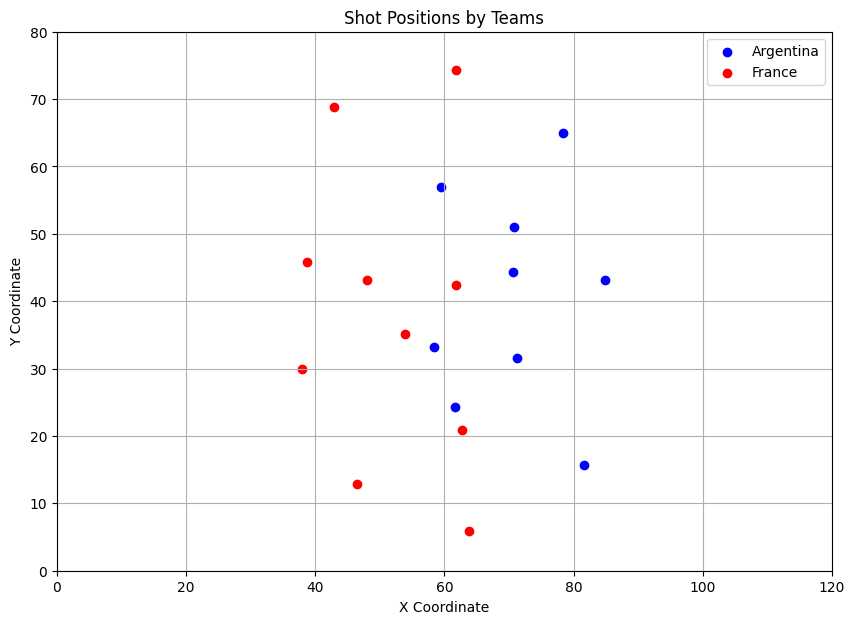

In [ ]:
import matplotlib.pyplot as plt

def plot_frame(frame):
    # Assuming 'location' column is in the format [x, y]
    defending_locations = [player['location'] for player in frame if not player['teammate'] and 'location' in player]
    attacking_locations = [player['location'] for player in frame if player['teammate'] and 'location' in player]
    team_names = ["Argentina", "France"]
    print(team_names)
        # Calculate dimensions
    if defending_locations:
        def_x_vals, def_y_vals = zip(*defending_locations)

    if attacking_locations:
        att_x_vals, att_y_vals = zip(*attacking_locations)

    # Plotting
    plt.figure(figsize=(10, 7))
    plt.scatter(def_x_vals,def_y_vals, c='blue', label=team_names[0])
    plt.scatter(att_x_vals,att_y_vals, c='red', label=team_names[1])

    plt.title('Shot Positions by Teams')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    # Set x and y limits
    plt.xlim(0, 120)
    plt.ylim(0, 80)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
iter = 0
for frame in events360M[events360M["match_id"]==3869685]["freeze_frame"]:
  if iter%30: #pick a random event
    plot_frame(frame)
    break
  else:
    iter += 1

Plot open pass lines for single frames

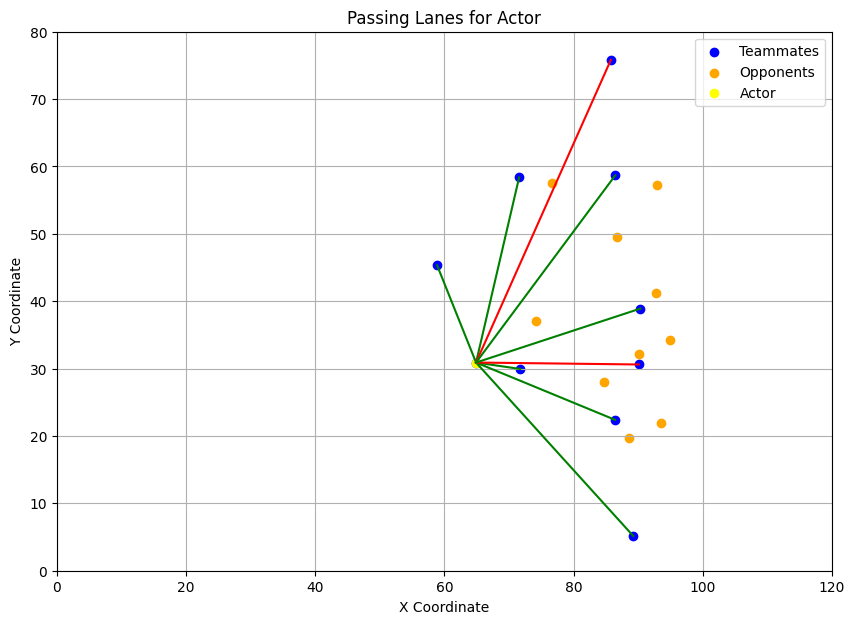

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def is_point_near_line(point, line_start, line_end, threshold=2.0):
    # Function to check if a point is near a line within a certain threshold
    px, py = point
    x1, y1 = line_start
    x2, y2 = line_end

    # Ensure line is not a single point
    if (x1, y1) == (x2, y2):
        return np.hypot(px - x1, py - y1) <= threshold

    # Calculate the projection of the point onto the line (defined by line_start and line_end)
    norm = np.hypot(x2 - x1, y2 - y1)
    u = ((px - x1) * (x2 - x1) + (py - y1) * (y2 - y1)) / (norm ** 2)

    # The point of intersection on the line segment
    closest_point = np.array([x1, y1]) + u * np.array([x2 - x1, y2 - y1])

    # Check if closest point is within line segment
    if u < 0 or u > 1:
        return False

    # Distance from the point to the closest point on the line segment
    distance = np.hypot(px - closest_point[0], py - closest_point[1])

    return distance <= threshold


def plot_passing_lanes(frame):
    # Find the actor
    actor = next((p for p in frame if p.get('actor') and p.get('location')), None)
    if not actor:
        return "No actor found in the frame."

    # Separate teammates and opponents
    teammates = [p for p in frame if p.get('teammate') and p.get('location')]
    opponents = [p for p in frame if not p.get('teammate') and p.get('location')]
    actor_loc = actor['location']

    # Plotting
    plt.figure(figsize=(10, 7))
    plt.scatter([p['location'][0] for p in teammates], [p['location'][1] for p in teammates], c='blue', label='Teammates')
    plt.scatter([p['location'][0] for p in opponents], [p['location'][1] for p in opponents], c='orange', label='Opponents')
    plt.scatter(actor_loc[0], actor_loc[1], c='yellow', label='Actor')

    # Draw lines and color them
    for teammate in teammates:
        teammate_loc = teammate['location']
        line_color = 'green' if all(not is_point_near_line(opponent['location'], actor_loc, teammate_loc) for opponent in opponents) else 'red'
        plt.plot([actor_loc[0], teammate_loc[0]], [actor_loc[1], teammate_loc[1]], color=line_color)

    plt.title('Passing Lanes for Actor')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 120)
    plt.ylim(0, 80)
    plt.legend()
    plt.grid(True)
    plt.show()
iter = 0
for frame in events360M[events360M["match_id"]==3869685]["freeze_frame"]:
  if iter > 638: #pick a random event
    plot_passing_lanes(frame)
    break
  else:
    iter += 1

Plot Amount of players in radius concept plot

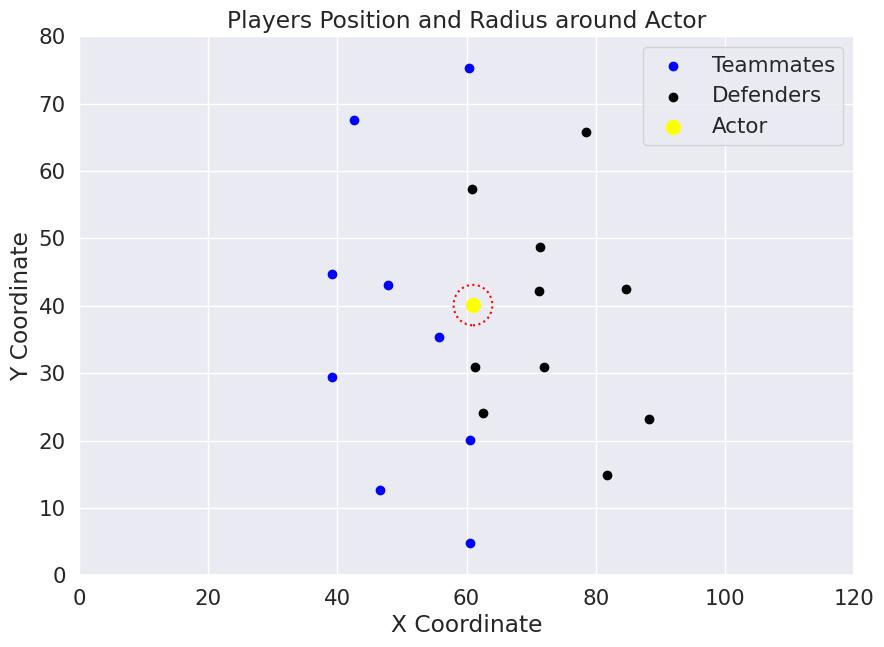

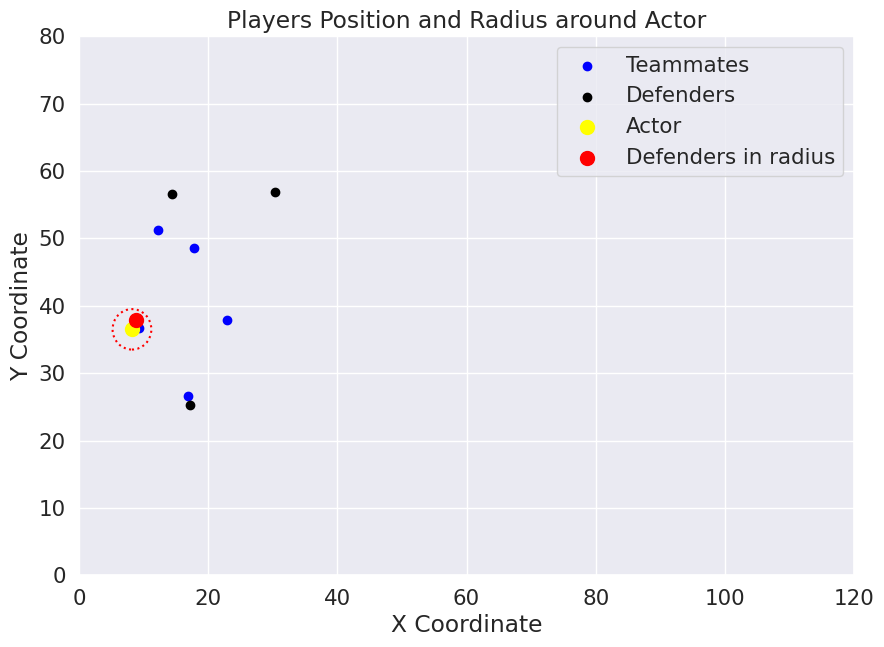

In [145]:
def plot_players_in_radius(frame, radius=3):
    # Define colors for the plot
    color_actor = 'yellow'
    color_teammate = 'blue'
    color_defender = 'black'
    color_defender_in_radius = 'red'
    color_circle = 'red'

    # Find the actor
    actor = next((p for p in frame if p.get('actor') and p.get('location')), None)
    if not actor:
        return "No actor found in the frame."

    # Separate teammates and opponents
    teammates = [p for p in frame if p.get('teammate') and p.get('location')]
    opponents = [p for p in frame if not p.get('teammate') and p.get('location')]
    actor_loc = actor['location']

    # Plotting
    plt.figure(figsize=(10, 7))
    plt.scatter([p['location'][0] for p in teammates], [p['location'][1] for p in teammates], c=color_teammate, label='Teammates')
    plt.scatter([p['location'][0] for p in opponents], [p['location'][1] for p in opponents], c=color_defender, label='Defenders')
    plt.scatter(actor_loc[0], actor_loc[1], c=color_actor, label='Actor', s=100)  # Actor highlighted

    # Draw the circle around the actor
    circle = plt.Circle((actor_loc[0], actor_loc[1]), radius, color=color_circle, fill=False, linestyle='dotted', linewidth=1.5)
    plt.gca().add_artist(circle)

    # Highlight defenders within the radius in red
    for opponent in opponents:
        dist_to_actor = np.hypot(opponent['location'][0] - actor_loc[0], opponent['location'][1] - actor_loc[1])
        if dist_to_actor <= radius:
            plt.scatter(opponent['location'][0], opponent['location'][1], c=color_defender_in_radius, label='Defenders in radius', s=100)

    plt.title('Players Position and Radius around Actor')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 120)
    plt.ylim(0, 80)
    plt.legend()
    plt.grid(True)
    plt.show()

iter = 0
for frame in events360M[events360M["match_id"]==3869685]["freeze_frame"]:
  if iter %2000==0: #pick a random event
    plot_players_in_radius(frame)

  iter += 1


Plot Area covered concept

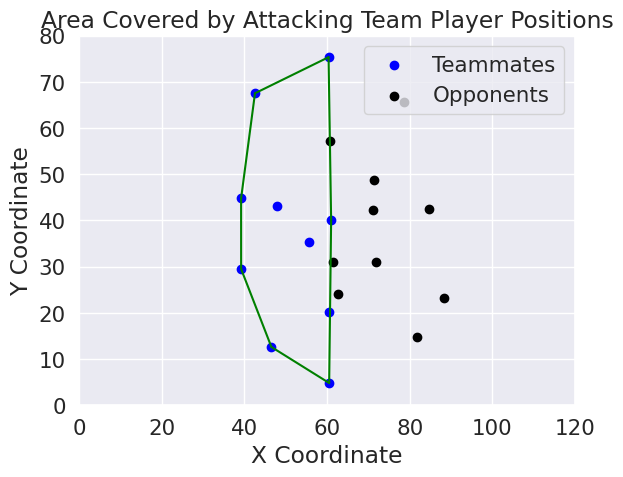

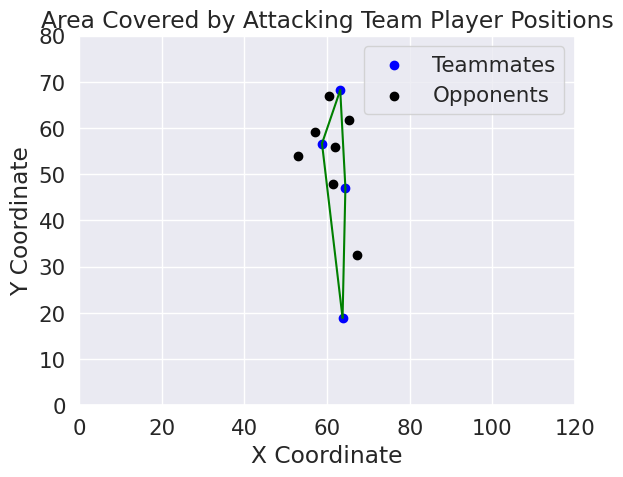

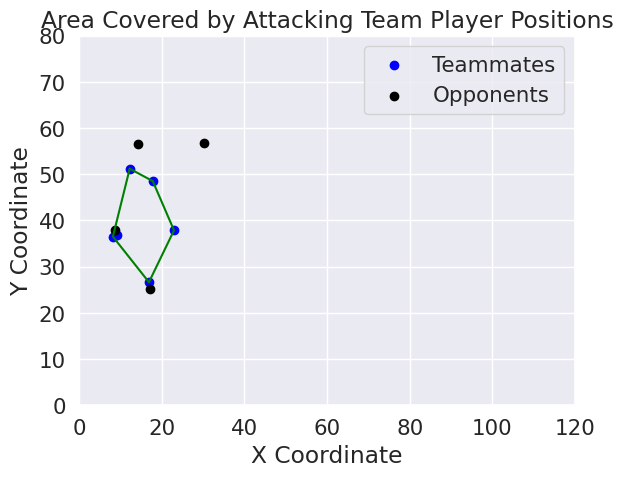

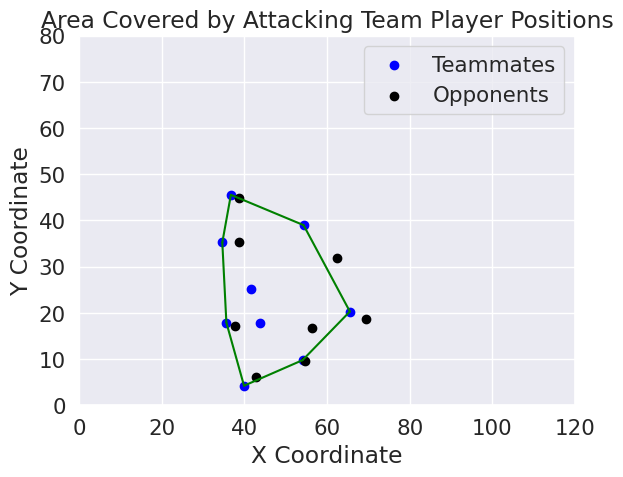

In [147]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

def plot_team_area(frame):
    # Define colors for the plot
    color_teammate = 'blue'
    color_opponent = 'black'
    color_hull = 'green'

    # Extract player locations
    teammate_locs = np.array([p['location'] for p in frame if p.get('teammate') and 'location' in p])
    opponent_locs = np.array([p['location'] for p in frame if not p.get('teammate') and 'location' in p])

    # Calculate convex hull for the attacking team
    if len(teammate_locs) >= 3:  # At least 3 points are needed to form a convex hull
        hull = ConvexHull(teammate_locs)
        for simplex in hull.simplices:
            plt.plot(teammate_locs[simplex, 0], teammate_locs[simplex, 1], color_hull)

    # Plot the players
    plt.scatter(teammate_locs[:, 0], teammate_locs[:, 1], c=color_teammate, label='Teammates')
    plt.scatter(opponent_locs[:, 0], opponent_locs[:, 1], c=color_opponent, label='Opponents')

    plt.title('Area Covered by Attacking Team Player Positions')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 120)
    plt.ylim(0, 80)
    plt.legend()
    plt.grid(True)
    plt.show()

iter = 0
for frame in events360M[events360M["match_id"]==3869685]["freeze_frame"]:
  if iter %1000==0: #pick a random event
    plot_team_area(frame)

  iter += 1



Plot conceptual graph of the feature of heterogeneity and compactness

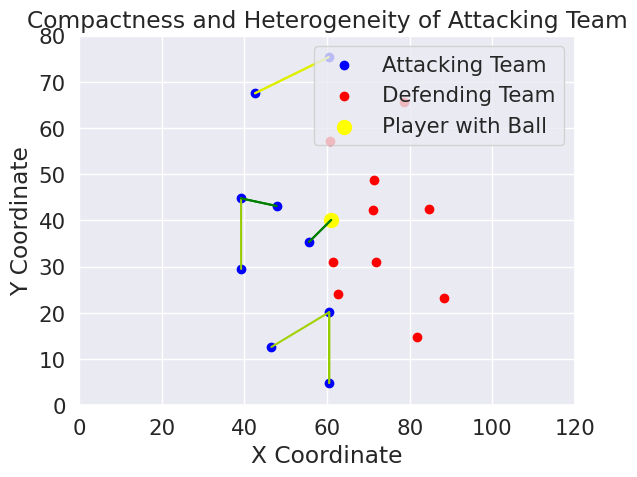

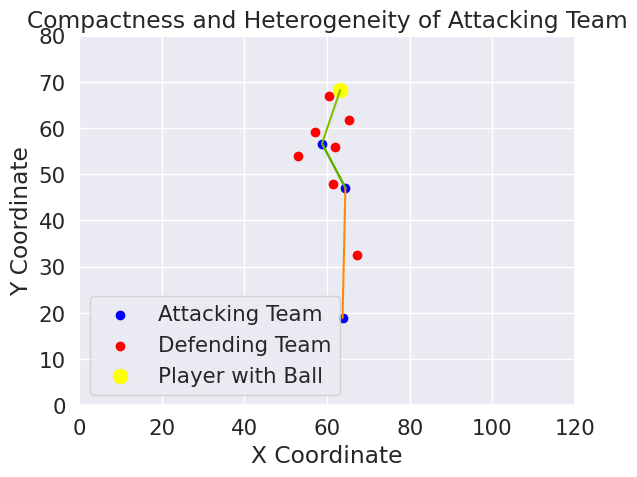

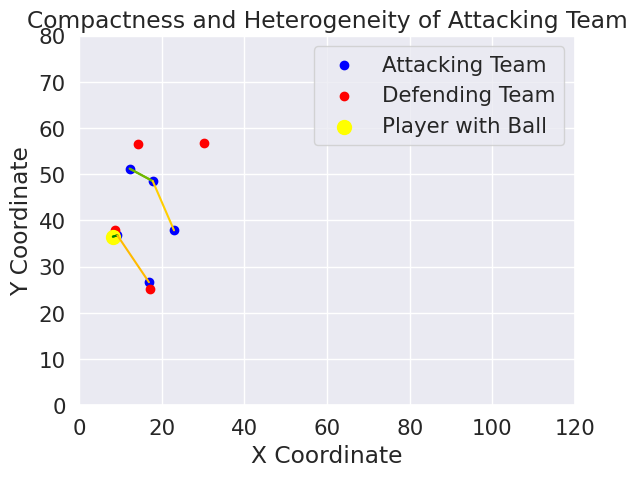

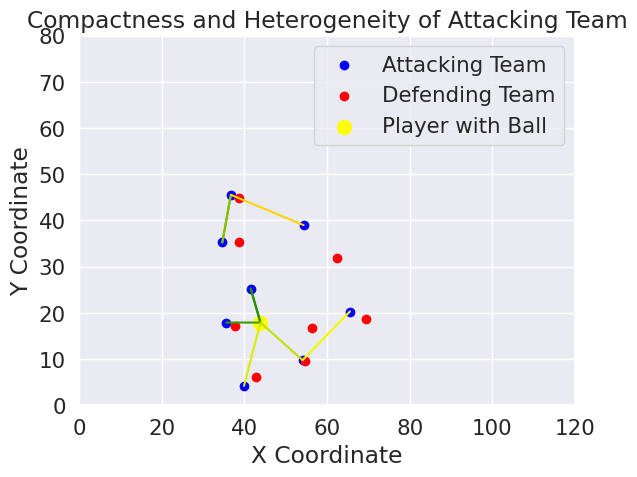

In [155]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.colors as mcolors

def plot_team_compactness_heterogeneity(frame):
    # Extract attacking and defending team locations and find the actor
    attacking_players = np.array([p['location'] for p in frame if p.get('teammate') and 'location' in p])
    defending_players = np.array([p['location'] for p in frame if not p.get('teammate') and 'location' in p])
    actor = next((p for p in frame if p.get('actor') and p.get('location')), None)

    if len(attacking_players) > 1:
        distances = cdist(attacking_players, attacking_players)
        np.fill_diagonal(distances, np.inf)  # Ignore self-distances

        mean_distance = np.mean(distances[distances != np.inf])

        # Define a colormap for the lines, using a gradient from green (close to mean) to red (far from mean)
        cmap = mcolors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])

        # Normalize the distances to use with the colormap
        norm = mcolors.Normalize(vmin=np.log(0.3 * mean_distance), vmax=np.log(1.7 * mean_distance))

        # Plot players
        plt.scatter(attacking_players[:, 0], attacking_players[:, 1], c='blue', label='Attacking Team')
        plt.scatter(defending_players[:, 0], defending_players[:, 1], c='red', label='Defending Team')
        if actor:
            plt.scatter(actor['location'][0], actor['location'][1], c='yellow', label='Player with Ball', s=100)

        # Draw lines and apply colors based on distance
        for idx, player in enumerate(attacking_players):
            closest_teammate_idx = np.argmin(distances[idx])
            closest_teammate = attacking_players[closest_teammate_idx]
            distance_to_closest_teammate = distances[idx, closest_teammate_idx]

            # Get color for the line based on distance
            line_color = cmap(norm(np.log(distance_to_closest_teammate)))

            # Draw the line
            plt.plot([player[0], closest_teammate[0]], [player[1], closest_teammate[1]], color=line_color)

    plt.title('Compactness and Heterogeneity of Attacking Team')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.xlim(0, 120)
    plt.ylim(0, 80)
    plt.grid(True)
    plt.show()


iter = 0
for frame in events360M[events360M["match_id"]==3869685]["freeze_frame"]:
  if iter %1000==0: #pick a random event
    plot_team_compactness_heterogeneity(frame)
  iter += 1



Plot The man to man marking lines

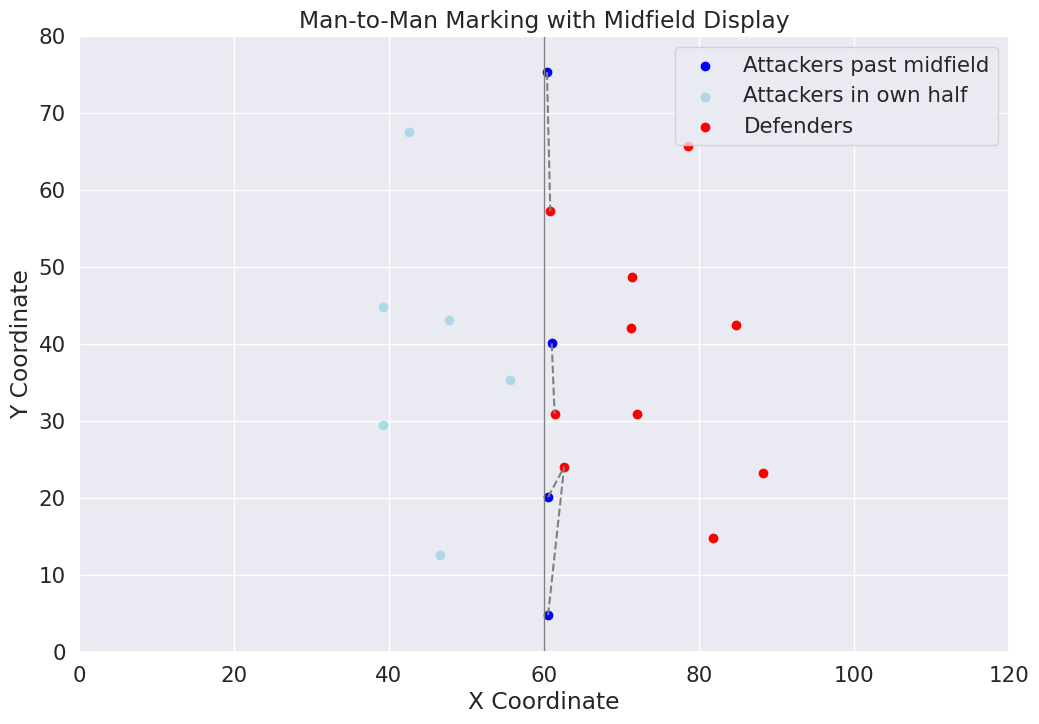

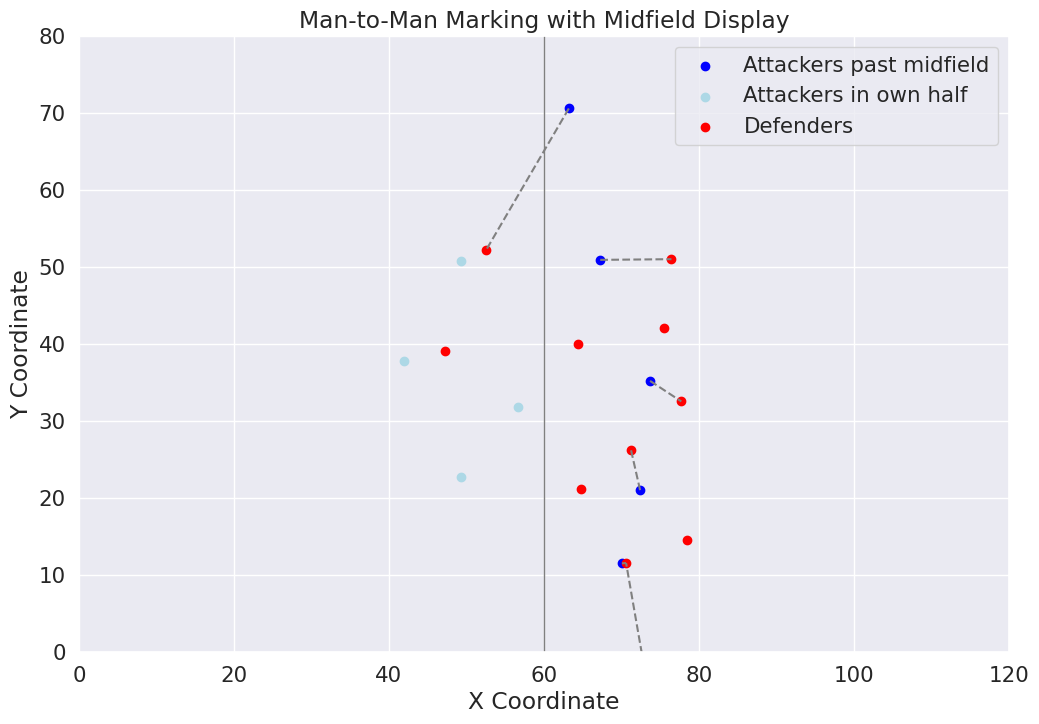

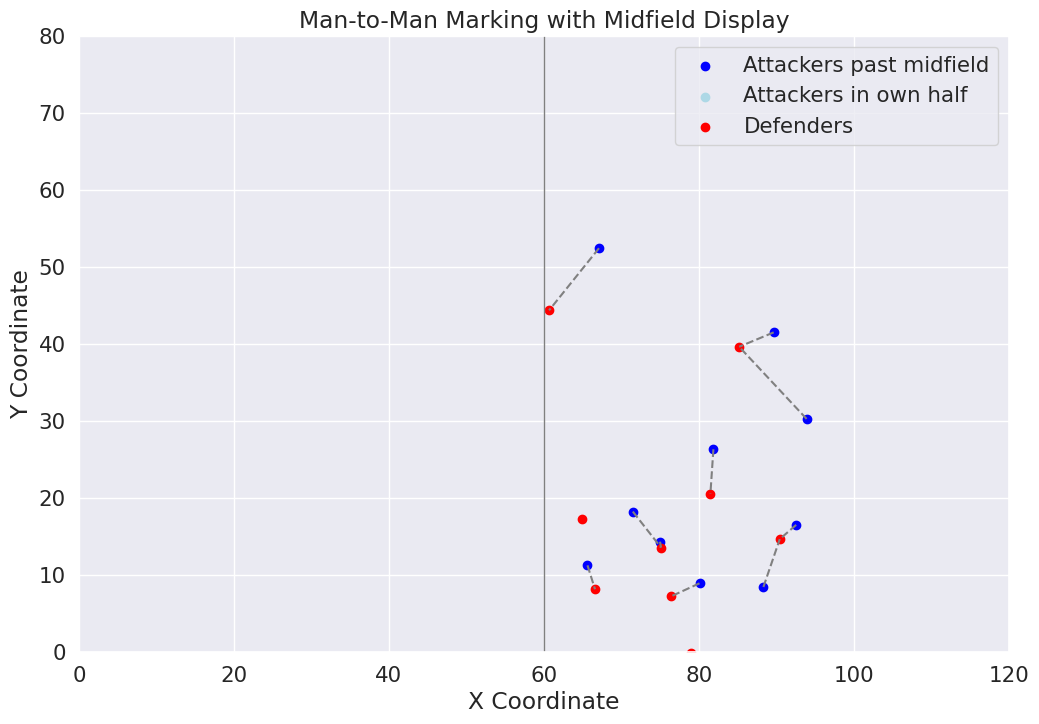

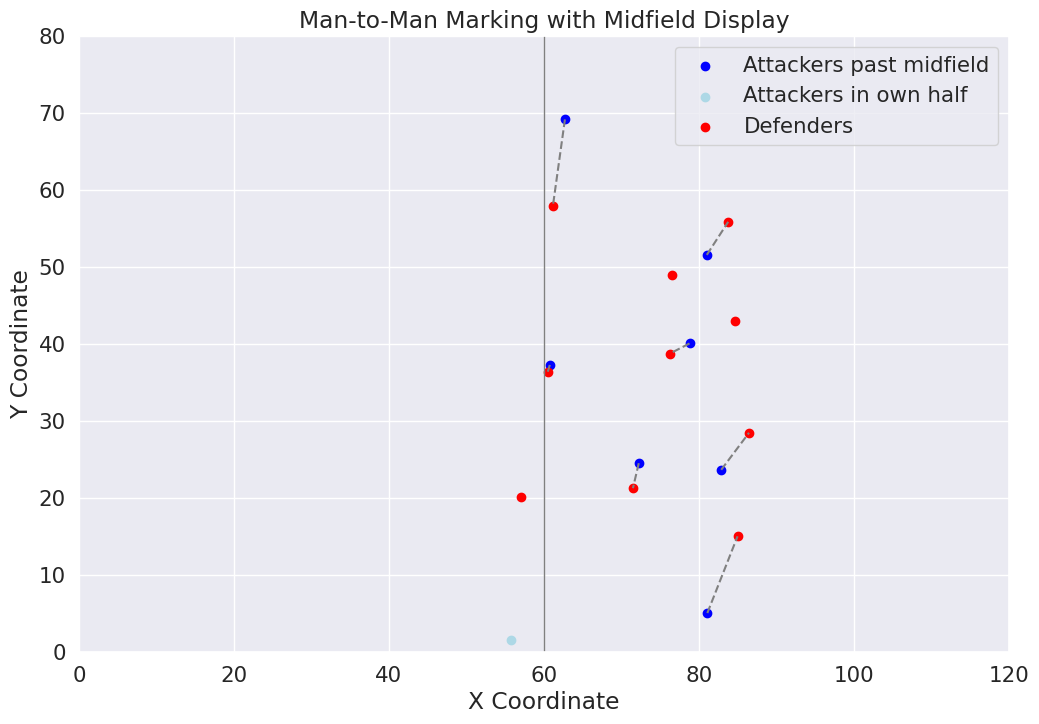

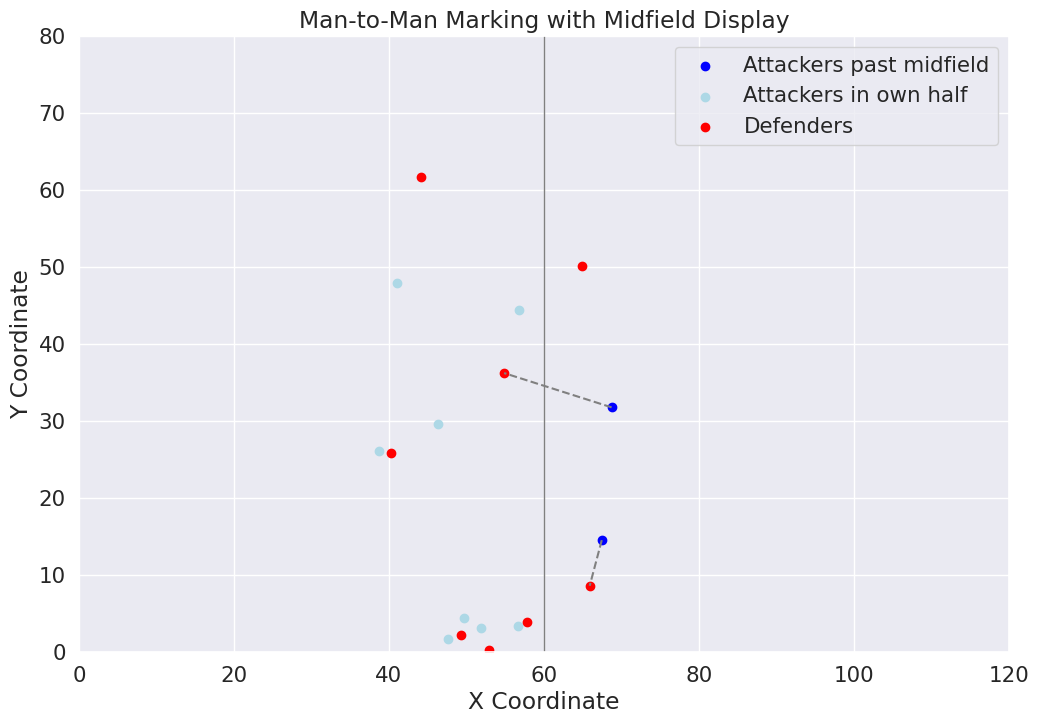

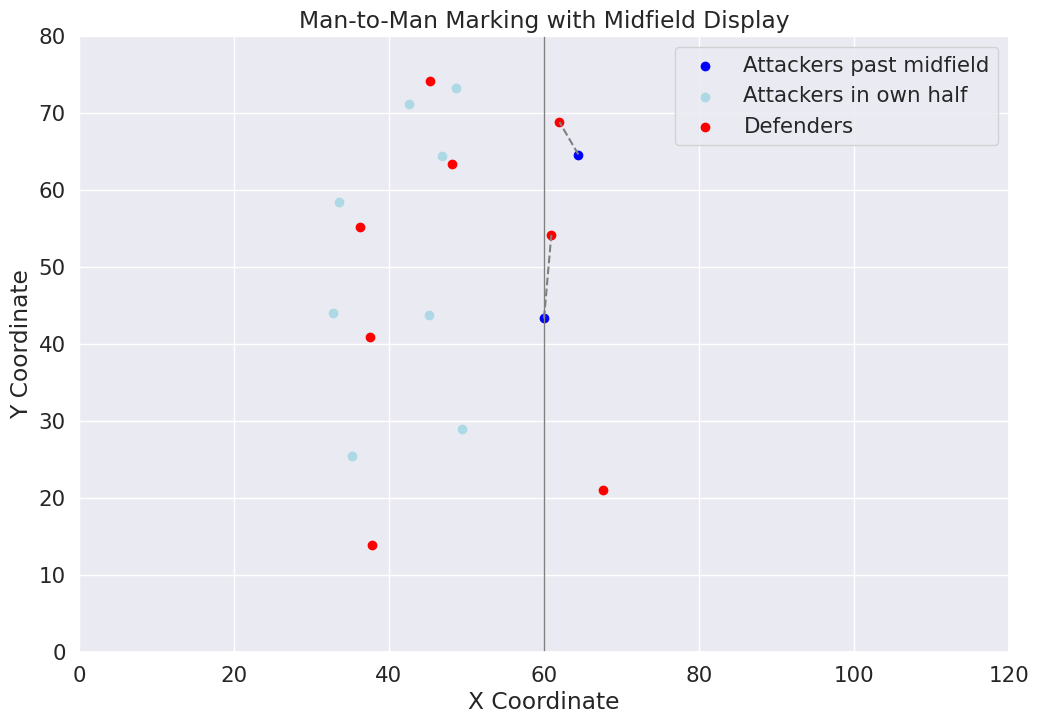

In [160]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

def plot_man_to_man_marking_with_midfield(frame):
    # Define colors for the plot
    color_attacker_midfield = 'lightblue'
    color_attacker = 'blue'
    color_defender = 'red'

    # Extract player locations
    attackers = np.array([player['location'] for player in frame if player.get('teammate')])
    defenders = np.array([player['location'] for player in frame if not player.get('teammate')])

    # Split attackers based on their field position
    attackers_midfield = attackers[attackers[:, 0] <= 60]
    attackers_past_midfield = attackers[attackers[:, 0] > 60]

    # Calculate pairwise distances and plot
    if len(attackers_past_midfield) > 0 and len(defenders) > 0:
        distances = cdist(attackers_past_midfield, defenders)
        closest_defenders_indices = np.argmin(distances, axis=1)

    plt.figure(figsize=(12, 8))

    # Draw midfield line
    plt.axvline(x=60, color='grey', linestyle='-', lw=1)

    # Plot attackers and defenders
    plt.scatter(attackers_past_midfield[:, 0], attackers_past_midfield[:, 1], c=color_attacker, label='Attackers past midfield')
    plt.scatter(attackers_midfield[:, 0], attackers_midfield[:, 1], c=color_attacker_midfield, label='Attackers in own half')
    plt.scatter(defenders[:, 0], defenders[:, 1], c=color_defender, label='Defenders')

    # Draw lines for attackers past midfield
    if len(attackers_past_midfield) > 0 and len(defenders) > 0:
        for attacker_idx, defender_idx in enumerate(closest_defenders_indices):
            attacker = attackers_past_midfield[attacker_idx]
            defender = defenders[defender_idx]
            plt.plot([attacker[0], defender[0]], [attacker[1], defender[1]], c='grey', linestyle='--')

    plt.title('Man-to-Man Marking with Midfield Display')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 120)
    plt.ylim(0, 80)
    plt.legend()
    plt.grid(True)
    plt.show()


iter = 0
for frame in events360M[events360M["match_id"]==3869685]["freeze_frame"]:
  if iter %620==0: #pick a random event
    plot_man_to_man_marking_with_midfield(frame)

  iter += 1


# Data analysis


Data analysis with events360 data

In [94]:
def remove_columns_with_excess_nans(df, max_nan_count=50):
    """
    Remove columns from the DataFrame that have more than max_nan_count NaN values.

    Parameters:
    df (pandas.DataFrame): The DataFrame to process.
    max_nan_count (int): The maximum allowed number of NaN values in a column.

    Returns:
    pandas.DataFrame: A DataFrame with columns removed that had more than max_nan_count NaN values.
    """
    # Count the NaN values in each column
    nan_counts = df.isna().sum()

    # Identify columns where the number of NaN values is greater than max_nan_count
    columns_to_drop = nan_counts[nan_counts > max_nan_count].index

    # Drop these columns
    df_dropped = df.drop(columns=columns_to_drop)

    return df_dropped


match_statsM["gender"] = 0
match_statsW["gender"] = 1
featuresEvents = pd.concat([match_statsM, match_statsW], ignore_index = True)
features360 = pd.concat([match_stats360M, match_stats360W], ignore_index = True)
raw_features = pd.merge(featuresEvents, features360, on='match_id', how='inner')
print(raw_features.shape)
clean_men = remove_columns_with_excess_nans(raw_features[raw_features["gender"]==0], 32)
clean_women = remove_columns_with_excess_nans(raw_features[raw_features["gender"]==1], 32)
features = pd.concat([clean_men, clean_women], ignore_index = True)

features = features.drop(columns = ["match_id", "duration"])
print(features.shape)


(128, 170)
(128, 152)


## Calculate Correlation Matrix

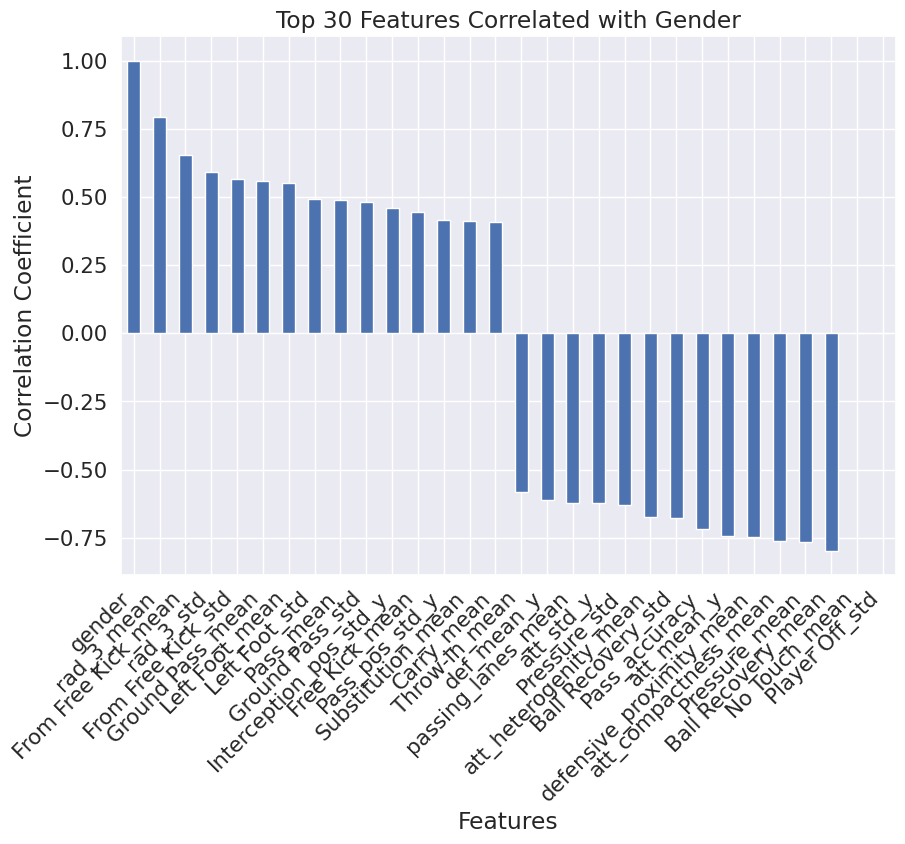

In [93]:
# Calculate correlation matrix
correlation_matrix = features.corr()

# If you're specifically interested in correlation with the gender, you may extract that column
gender_corr = correlation_matrix['gender']
top_features = gender_corr.sort_values(ascending=False)
top_15_features = top_features.head(15)
last_15_features = top_features.tail(15)
top_30_features = pd.concat([top_15_features,last_15_features])
# Plot
plt.figure(figsize=(10, 7))
top_30_features.plot(kind='bar')
plt.title('Top 30 Features Correlated with Gender')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better readability
plt.show()


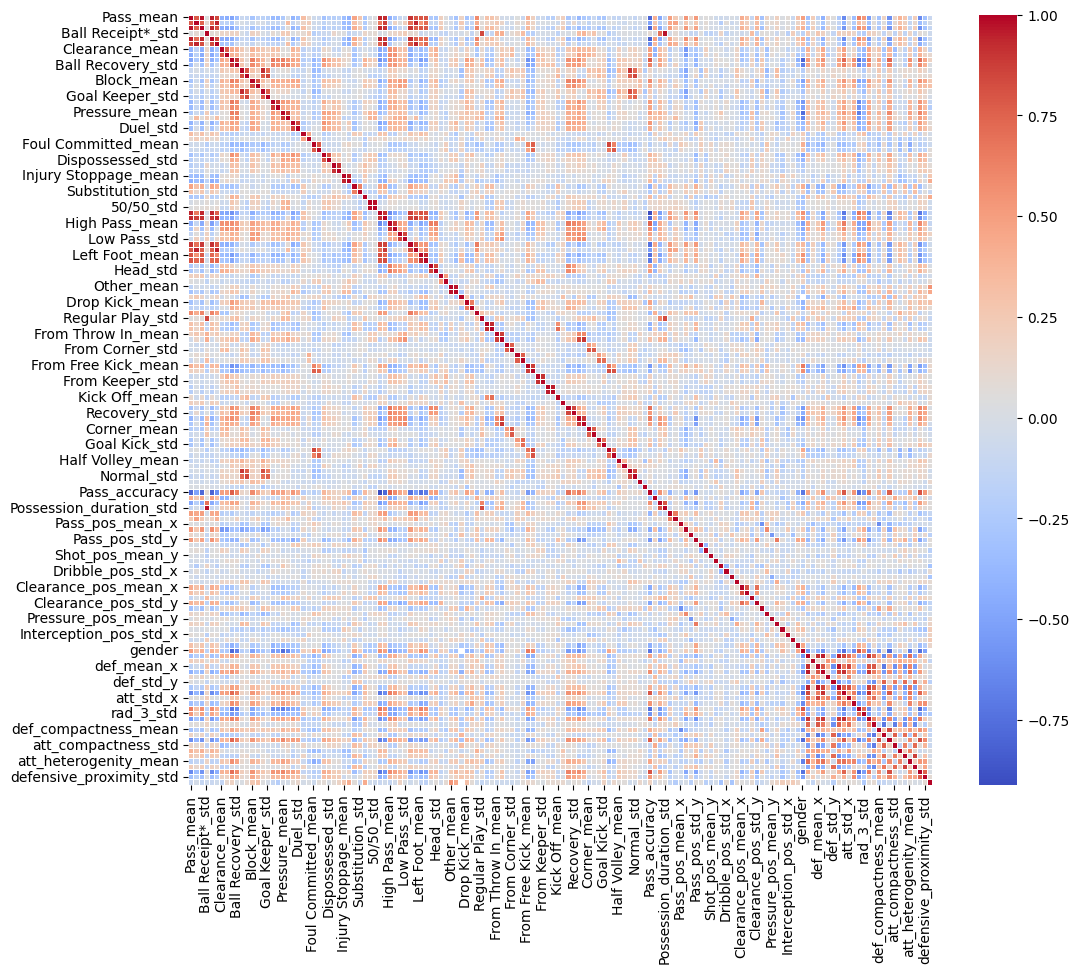

In [28]:
# All correlations, not only gender related
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)
plt.show()

## Information Entropy regression

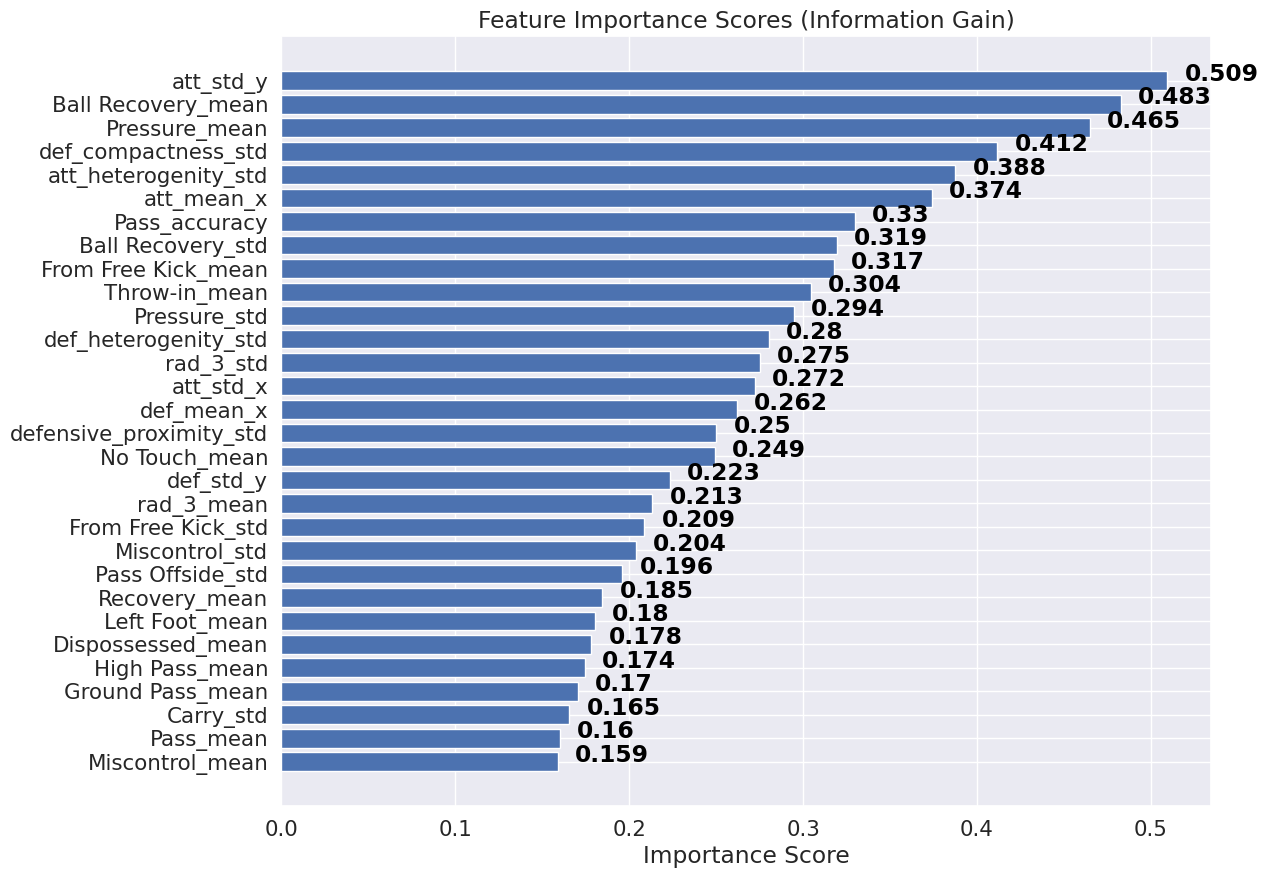

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
X = features.fillna(features.mean()).drop('gender', axis=1)  # Features
y = features['gender'].fillna(features.mean())
# Apply Information Gain
ig = mutual_info_regression(X, y)

# Create a dictionary of feature importance scores
feature_scores = {}
for i in range(len(features.columns)-1):
    feature_scores[features.columns[i]] = ig[i]

# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
sorted_features_top20 = sorted_features[:30]

# Plot a horizontal bar chart of the feature importance scores
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(sorted_features_top20))
ax.barh(y_pos, [score for feature, score in sorted_features_top20], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels([feature for feature, score in sorted_features_top20])
ax.invert_yaxis()  # Labels read top-to-bottom
ax.set_xlabel("Importance Score")
ax.set_title("Feature Importance Scores (Information Gain)")

# Add importance scores as labels on the horizontal bar chart
for i, v in enumerate([score for feature, score in sorted_features_top20]):
    ax.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
plt.show()

## Random Forest

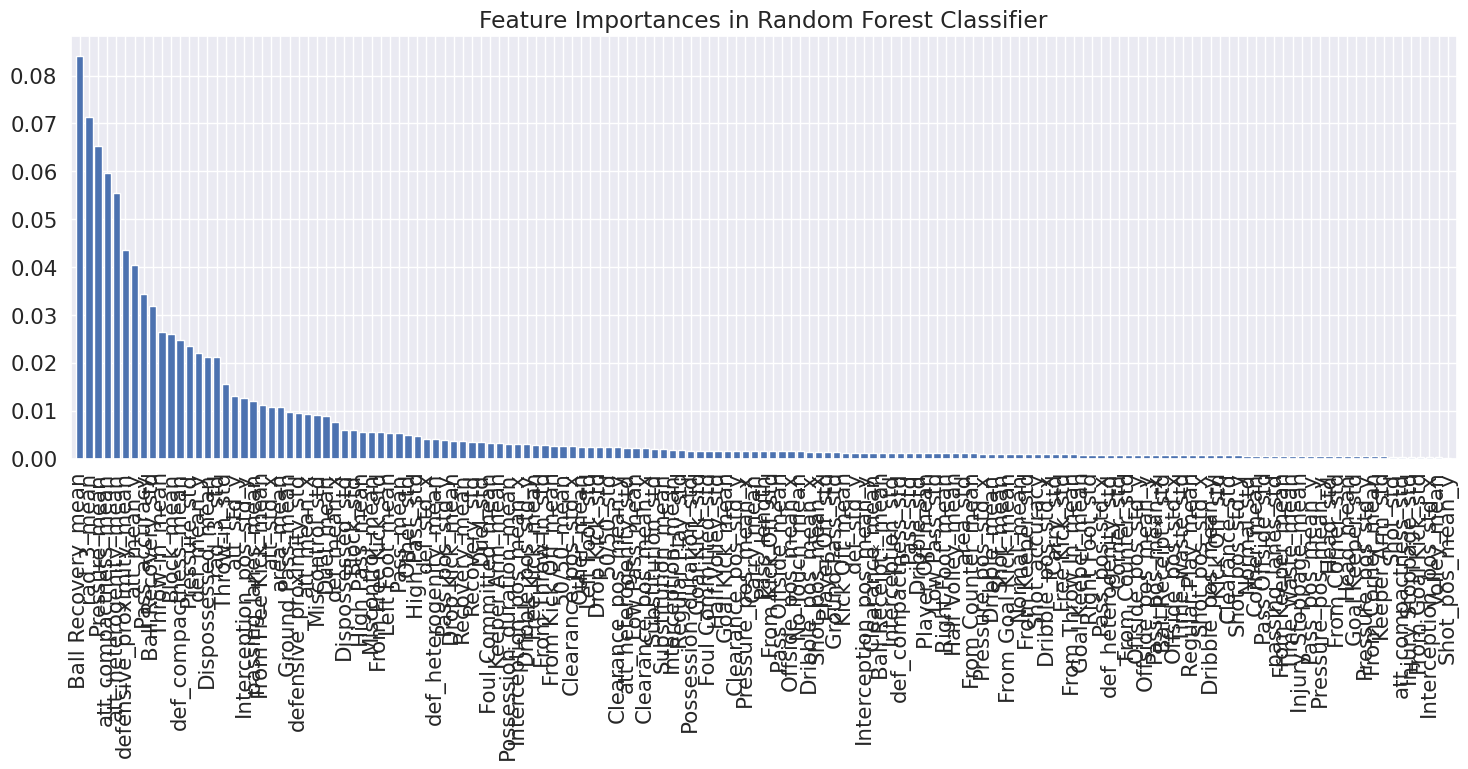

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# Splitting the data
X = features.drop('gender', axis=1).fillna(features.mean())  # Features
y = features['gender'].fillna(features.mean())               # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# Initialize the model
rf = RandomForestClassifier(n_estimators=1000, random_state=42)

# Train the model
rf.fit(X_train, y_train)
# Get feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
# Plotting
plt.figure(figsize=(15, 8))
plt.title('Feature Importances in Random Forest Classifier')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

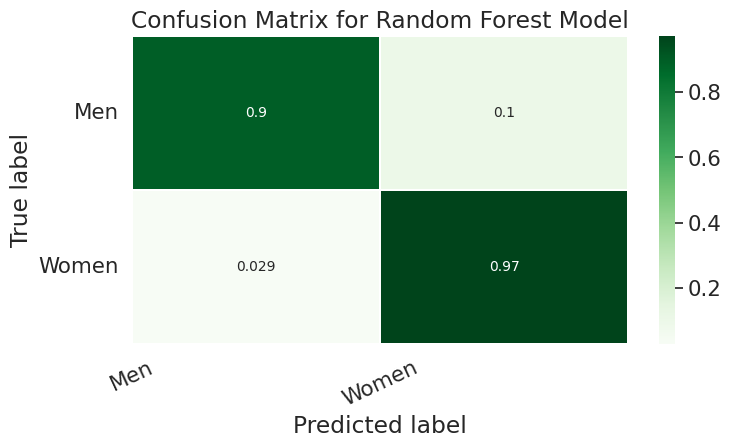

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Make predictions for the test set
y_pred = rf.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)

matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(8,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Men', 'Women']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

## Wrapper approach

Selected Features: ('Ball Recovery_mean', 'Ball Recovery_std', 'Pressure_mean', 'defensive_proximity_mean', 'From Free Kick_mean', 'From Free Kick_std', 'Throw-in_mean', 'rad_3_mean', 'rad_3_std', 'Pass_mean')
Accuracy: 1.0


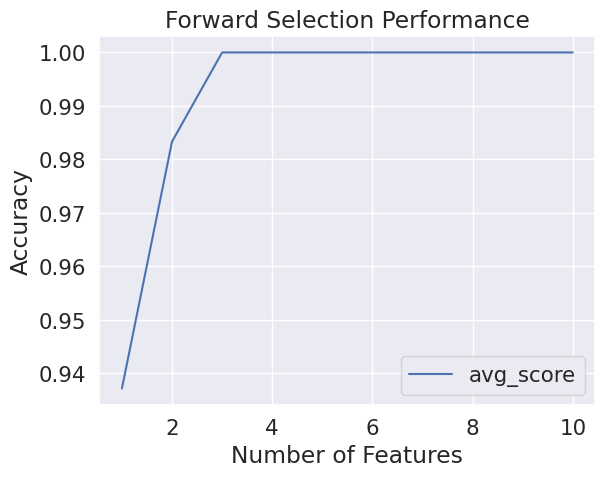

In [133]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Split the dataset into features and target
X = final_features.drop('gender', axis=1).fillna(final_features.mean())  # Features
y = final_features['gender'].fillna(final_features.mean())               # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# Define the logistic regression model
model = LogisticRegression()

# Define the forward selection object
sfs = SFS(model, k_features=10, forward=True, floating=False, scoring="accuracy", cv=5)

# Perform forward selection on the training set
sfs.fit(X_train, y_train)

# Print the selected features
print("Selected Features:", sfs.k_feature_names_)

# Evaluate the performance of the selected features on the testing set
accuracy = sfs.k_score_
print("Accuracy:", accuracy)

# Plot the performance of the model with different feature subsets
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Forward Selection Performance")
plt.show()

## Testing final Feature Selection on different algorithms

Selecting the features

In [120]:
final_features_list = ['Ball Recovery_mean', 'Ball Recovery_std', 'Pressure_mean', 'defensive_proximity_mean',
                       'From Free Kick_mean', 'From Free Kick_std', 'Throw-in_mean', 'rad_3_mean', 'rad_3_std', 'Pass_mean', "gender"]
print(len(final_features_list))
final_features = features[final_features_list]


11


Train a SFS on final features

Selected Features: ('Ball Recovery_mean', 'Ball Recovery_std', 'Pressure_mean', 'defensive_proximity_mean', 'From Free Kick_mean', 'From Free Kick_std', 'Throw-in_mean', 'rad_3_mean', 'rad_3_std', 'Pass_mean')
Accuracy: 1.0


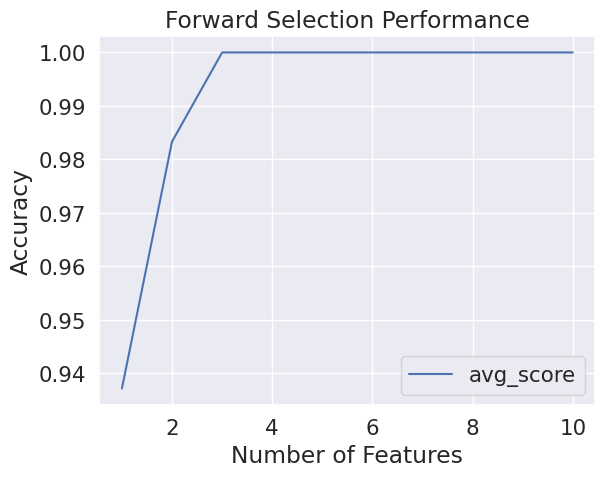

In [130]:
# Split the dataset into features and target
X = final_features.drop('gender', axis=1).fillna(features.mean())  # Features
y = final_features['gender'].fillna(features.mean())               # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=2)

# Define the logistic regression model
model = LogisticRegression()

# Define the forward selection object
sfs = SFS(model, k_features=10, forward=True, floating=False, scoring="accuracy", cv=5)

# Perform forward selection on the training set
sfs.fit(X_train, y_train)

# Print the selected features
print("Selected Features:", sfs.k_feature_names_)

# Evaluate the performance of the selected features on the testing set
accuracy = sfs.k_score_
print("Accuracy:", accuracy)

# Plot the performance of the model with different feature subsets
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Forward Selection Performance")
plt.show()

Train a softmax on final features

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming final_features is your DataFrame and 'gender' is the target variable

# Split the dataset into features and target
X = final_features.drop('gender', axis=1).fillna(final_features.mean())  # Features
y = final_features['gender']                                       # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=2)

# Instantiate and fit the logistic regression model with the 'multinomial' option for softmax
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Softmax Regression:", accuracy)



Accuracy with Softmax Regression: 0.96875


Train a Random Forest on final features

In [127]:
from sklearn.ensemble import RandomForestClassifier
# Split the dataset into features and target
X = final_features.drop('gender', axis=1).fillna(features.mean())  # Features
y = final_features['gender'].fillna(features.mean())               # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=2)
# Instantiate and fit the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)


Random Forest Accuracy: 0.96875
